
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20?urlpath=lab/tree/tutorials/api/fitting.ipynb)
- You may download all the notebooks as a [tar file](../../_downloads/notebooks-0.20.tar).
- **Source files:**
[fitting.ipynb](../../_static/notebooks/fitting.ipynb) |
[fitting.py](../../_static/notebooks/fitting.py)
</div>


# Fitting


## Prerequisites

- Knowledge of spectral analysis to produce 1D On-Off datasets, [see the following tutorial](../analysis/1D/spectral_analysis.ipynb)
- Reading of pre-computed datasets [see the MWL tutorial](../analysis/3D/analysis_mwl.ipynb)
- General knowledge on statistics and optimization methods

## Proposed approach

This is a hands-on tutorial to `~gammapy.modeling`, showing how to do perform a Fit in gammapy. The emphasis here is on interfacing the `Fit` class and inspecting the errors. To see an analysis example of how datasets and models interact, see the [model management notebook](model_management.ipynb). As an example, in this notebook, we are going to work with HESS data of the Crab Nebula and show in particular how to :
- perform a spectral analysis
- use different fitting backends
- access covariance matrix information and parameter errors
- compute likelihood profile
- compute confidence contours

See also: [Models gallery tutorial](models.ipynb) and `docs/modeling/index.rst`.


## The setup

In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import scipy.stats as st
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling.models import LogParabolaSpectralModel, SkyModel
from gammapy.visualization.utils import plot_contour_line
from itertools import combinations

## Model and dataset

First we define the source model, here we need only a spectral model for which we choose a log-parabola

In [2]:
crab_spectrum = LogParabolaSpectralModel(
    amplitude=1e-11 / u.cm**2 / u.s / u.TeV,
    reference=1 * u.TeV,
    alpha=2.3,
    beta=0.2,
)

crab_spectrum.alpha.max = 3
crab_spectrum.alpha.min = 1
crab_model = SkyModel(spectral_model=crab_spectrum, name="crab")

The data and background are read from pre-computed ON/OFF datasets of HESS observations, for simplicity we stack them together.
Then we set the model and fit range to the resulting dataset.

In [3]:
datasets = []
for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.read(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce(name="HESS")
datasets = Datasets(datasets=[dataset_hess])

# Set model and fit range
dataset_hess.models = crab_model
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset_hess.mask_fit = dataset_hess.counts.geom.energy_mask(e_min, e_max)

## Fitting options



First let's create a `Fit` instance:

In [4]:
scipy_opts = {
    "method": "L-BFGS-B",
    "options": {"ftol": 1e-4, "gtol": 1e-05},
    "backend": "scipy",
}
fit_scipy = Fit(store_trace=True, optimize_opts=scipy_opts)

By default the fit is performed using MINUIT, you can select alternative optimizers and set their option using the `optimize_opts` argument of the `Fit.run()` method. In addition we have specified to store the trace of parameter values of the fit.

Note that, for now, covaraince matrix and errors are computed only for the fitting with MINUIT. However depending on the problem other optimizers can better perform, so sometimes it can be useful to run a pre-fit with alternative optimization methods.

For the "scipy" backend the available options are described in detail here:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [5]:
%%time
result_scipy = fit_scipy.run(datasets)

CPU times: user 287 ms, sys: 5.44 ms, total: 292 ms
Wall time: 332 ms


For the "sherpa" backend you can choose the optimization algorithm between method = {"simplex",  "levmar", "moncar", "gridsearch"}.  
Those methods are described and compared in detail on http://cxc.cfa.harvard.edu/sherpa/methods/index.html 
The available options of the optimization methods are described on the following page https://cxc.cfa.harvard.edu/sherpa/methods/opt_methods.html

In [6]:
%%time
sherpa_opts = {"method": "simplex", "ftol": 1e-3, "maxfev": int(1e4)}
fit_sherpa = Fit(store_trace=True, backend="sherpa", optimize_opts=sherpa_opts)
results_simplex = fit_sherpa.run(datasets)

ModuleNotFoundError: No module named 'sherpa'

For the "minuit" backend see https://iminuit.readthedocs.io/en/latest/reference.html for a detailed description of the available options. If there is an entry ‘migrad_opts’, those options will be passed to [iminuit.Minuit.migrad](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.migrad). Additionally you can set the fit tolerance using the [tol](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.tol
) option. The minimization will stop when the estimated distance to the minimum is less than 0.001*tol (by default tol=0.1). The [strategy](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.strategy) option change the speed and accuracy of the optimizer: 0 fast, 1 default, 2 slow but accurate. If you want more reliable error estimates, you should run the final fit with strategy 2.


In [7]:
%%time
fit = Fit(store_trace=True)
minuit_opts = {"tol": 0.001, "strategy": 1}
fit.backend = "minuit"
fit.optimize_opts = minuit_opts
result_minuit = fit.run(datasets)

CPU times: user 139 ms, sys: 3.12 ms, total: 142 ms
Wall time: 159 ms


## Fit quality assessment

There are various ways to check the convergence and quality of a fit. Among them:

Refer to the automatically-generated results dictionary:

In [8]:
print(result_scipy)

OptimizeResult

	backend    : scipy
	method     : L-BFGS-B
	success    : True
	message    : CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
	nfev       : 60
	total stat : 30.35

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [9]:
print(results_simplex)

NameError: name 'results_simplex' is not defined

In [10]:
print(result_minuit)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 52
	total stat : 30.35

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



If the fit is performed with minuit you can print detailed informations to check the convergence

In [11]:
print(fit.minuit)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 30.35                      │              Nfcn = 52               │
│ EDM = 4.15e-10 (Goal: 2e-06)     │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

Check the trace of the fit e.g. in case the fit did not converge properly

In [12]:
result_minuit.trace

total_stat,crab.spectral.amplitude,crab.spectral.alpha,crab.spectral.beta
float64,float64,float64,float64
30.3500657162104,3.817289698656186e-11,2.197292407700903,0.22709127789012862
30.350283248175447,3.820841929575321e-11,2.197292407700903,0.22709127789012862
30.350222616485947,3.81373746773705e-11,2.197292407700903,0.22709127789012862
30.35007926860123,3.8179994706225424e-11,2.197292407700903,0.22709127789012862
30.350067112690233,3.816579926689829e-11,2.197292407700903,0.22709127789012862
30.352094318911043,3.817289698656186e-11,2.1999760722366375,0.22709127789012862
30.350029544745276,3.817289698656186e-11,2.19460726388853,0.22709127789012862
30.350179154484287,3.817289698656186e-11,2.1975608410540226,0.22709127789012862
30.349972202223313,3.817289698656186e-11,2.1970239595550076,0.22709127789012862


Check that the fitted values and errors for all parameters are reasonable, and no fitted parameter value is "too close" - or even outside - its allowed min-max range

In [13]:
result_minuit.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,3.8122e-11,cm-2 s-1 TeV-1,3.548e-12,nan,nan,False,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
spectral,alpha,2.1957e+00,,2.639e-01,1.000e+00,3.000e+00,False,False,
spectral,beta,2.2651e-01,,1.403e-01,nan,nan,False,False,


Plot fit statistic profiles for all fitted parameters, using `~gammapy.modeling.Fit.stat_profile()`. For a good fit and error estimate each profile should be parabolic. The specification for each fit statistic profile can be changed on the `~gammapy.modeling.Parameter` object, which has `.scan_min`, `.scan_max`, `.scan_n_values` and `.scan_n_sigma` attributes.

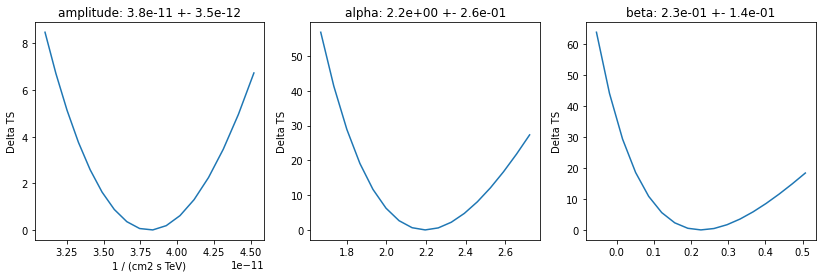

In [14]:
total_stat = result_minuit.total_stat

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))

for ax, par in zip(axes, crab_model.parameters.free_parameters):
    par.scan_n_values = 17

    profile = fit.stat_profile(datasets=datasets, parameter=par)
    ax.plot(profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat)
    ax.set_xlabel(f"{par.unit}")
    ax.set_ylabel("Delta TS")
    ax.set_title(f"{par.name}: {par.value:.1e} +- {par.error:.1e}")

Inspect model residuals. Those can always be accessed using `~Dataset.residuals()`, that will return an array in case a the fitted `Dataset` is a `SpectrumDataset` and a full cube in case of a `MapDataset`. For more details, we refer here to the dedicated fitting tutorials: [analysis_3d.ipynb](../analysis/3D/analysis_3d.ipynb) (for `MapDataset` fitting) and [spectrum_analysis.ipynb](../analysis/1D/spectral_analysis.ipynb) (for `SpectrumDataset` fitting).

## Covariance and parameters errors

After the fit the covariance matrix is attached to the model. You can get the error on a specific parameter by accessing the `.error` attribute:

In [15]:
crab_model.spectral_model.alpha.error

0.26387706255272814

And you can plot the total parameter correlation as well:

<AxesSubplot:>

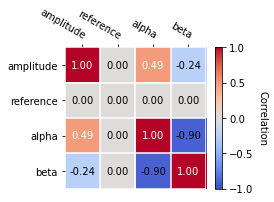

In [16]:
crab_model.covariance.plot_correlation()

As an example, this step is needed to produce a butterfly plot showing the envelope of the model taking into account parameter uncertainties.

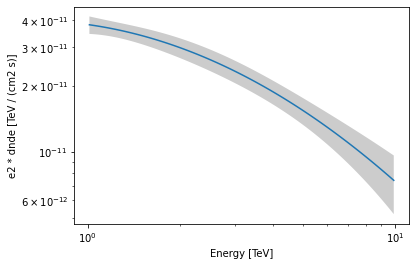

In [17]:
energy_bounds = [1, 10] * u.TeV
crab_spectrum.plot(energy_bounds=energy_bounds, energy_power=2)
ax = crab_spectrum.plot_error(energy_bounds=energy_bounds, energy_power=2)

## Confidence contours


In most studies, one wishes to estimate parameters distribution using observed sample data.
A 1-dimensional confidence interval gives an estimated range of values which is likely to include an unknown parameter.
A confidence contour is a 2-dimensional generalization of a confidence interval, often represented as an ellipsoid around the best-fit value.

Gammapy offers two ways of computing confidence contours, in the dedicated methods `Fit.minos_contour()` and `Fit.stat_profile()`. In the following sections we will describe them.

An important point to keep in mind is: *what does a $N\sigma$ confidence contour really mean?* The answer is it represents the points of the parameter space for which the model likelihood is $N\sigma$ above the minimum. But one always has to keep in mind that **1 standard deviation in two dimensions has a smaller coverage probability than 68%**, and similarly for all other levels. In particular, in 2-dimensions the probability enclosed by the $N\sigma$ confidence contour is $P(N)=1-e^{-N^2/2}$.

### Computing contours using `Fit.stat_contour()` 

After the fit, MINUIT offers the possibility to compute the confidence confours.
gammapy provides an interface to this functionality through the `Fit` object using the `.stat_contour` method.
Here we defined a function to automate the contour production for the different parameterer and confidence levels (expressed in term of sigma):

In [18]:
def make_contours(fit, datasets, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["alpha", "beta", "amplitude"], r=2):
            contour = fit.stat_contour(
                datasets=datasets,
                x=datasets.parameters[par_1],
                y=datasets.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[par_1].tolist(),
                par_2: contour[par_2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

Now we can compute few contours.

In [19]:
%%time
sigmas = [1, 2]
cts_sigma = make_contours(
    fit=fit,
    datasets=datasets,
    result=result_minuit,
    npoints=10,
    sigmas=sigmas,
)

/Users/adonath/software/mambaforge/envs/gammapy-dev/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


CPU times: user 10.5 s, sys: 130 ms, total: 10.6 s
Wall time: 13 s


Then we prepare some aliases and annotations in order to make the plotting nicer.

In [20]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
}

panels = [
    {
        "x": "alpha",
        "y": "phi",
        "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_alpha_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "beta",
        "y": "phi",
        "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_beta_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "alpha",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

Finally we produce the confidence contours figures.

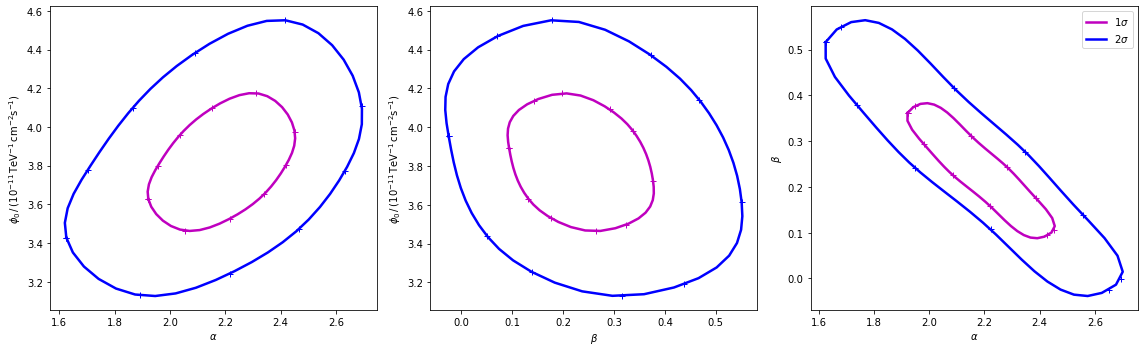

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigmas[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()

### Computing contours using `Fit.stat_surface()`

This alternative method for the computation of confidence contours, although more time consuming than `Fit.minos_contour()`, is expected to be more stable. It consists of a generalization of `Fit.stat_profile()` to a 2-dimensional parameter space. The algorithm is very simple:
- First, passing two arrays of parameters values, a 2-dimensional discrete parameter space is defined;
- For each node of the parameter space, the two parameters of interest are frozen. This way, a likelihood value ($-2\mathrm{ln}\,\mathcal{L}$, actually) is computed, by either freezing (default) or fitting all nuisance parameters;
- Finally, a 2-dimensional surface of $-2\mathrm{ln}(\mathcal{L})$ values is returned.
Using that surface, one can easily compute a surface of $TS = -2\Delta\mathrm{ln}(\mathcal{L})$ and compute confidence contours.

Let's see it step by step.

First of all, we can notice that this method is "backend-agnostic", meaning that it can be run with MINUIT, sherpa or scipy as fitting tools. Here we will stick with MINUIT, which is the default choice:

As an example, we can compute the confidence contour for the `alpha` and `beta` parameters of the `dataset_hess`. Here we define the parameter space:

In [22]:
result = result_minuit
par_alpha = datasets.parameters["alpha"]
par_beta = datasets.parameters["beta"]

par_alpha.scan_values = np.linspace(1.55, 2.7, 20)
par_beta.scan_values = np.linspace(-0.05, 0.55, 20)

Then we run the algorithm, by choosing `reoptimize=False` for the sake of time saving. In real life applications, we strongly recommend to  use `reoptimize=True`, so that all free nuisance parameters will be fit at each grid node. This is the correct way, statistically speaking, of computing confidence contours, but is expected to be time consuming.

In [23]:
fit = Fit(backend="minuit", optimize_opts={"print_level": 0})
stat_surface = fit.stat_surface(
    datasets=datasets,
    x=par_alpha,
    y=par_beta,
    reoptimize=False,
)

In order to easily inspect the results, we can convert the $-2\mathrm{ln}(\mathcal{L})$ surface to a surface of statistical significance (in units of Gaussian standard deviations from the surface minimum):

In [24]:
# Compute TS
TS = stat_surface["stat_scan"] - result.total_stat

In [25]:
# Compute the corresponding statistical significance surface
stat_surface = np.sqrt(TS.T)

Notice that, as explained before, $1\sigma$ contour obtained this way will not contain 68% of the probability, but rather 

In [26]:
# Compute the corresponding statistical significance surface
# p_value = 1 - st.chi2(df=1).cdf(TS)
# gaussian_sigmas = st.norm.isf(p_value / 2).T

Finally, we can plot the surface values together with contours:

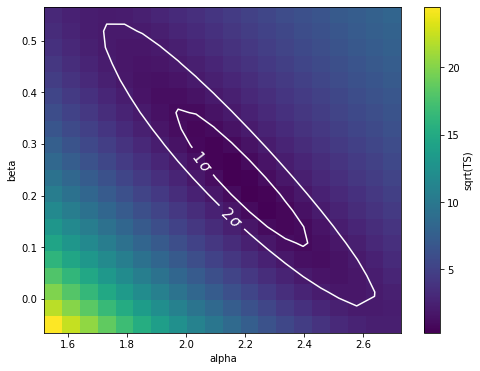

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
x_values = par_alpha.scan_values
y_values = par_beta.scan_values

# plot surface
im = ax.pcolormesh(x_values, y_values, stat_surface, shading="auto")
fig.colorbar(im, label="sqrt(TS)")
ax.set_xlabel(f"{par_alpha.name}")
ax.set_ylabel(f"{par_beta.name}")

# We choose to plot 1 and 2 sigma confidence contours
levels = [1, 2]
contours = ax.contour(
    x_values, y_values, stat_surface, levels=levels, colors="white"
)
ax.clabel(contours, fmt="%.0f$\,\sigma$", inline=3, fontsize=15);

Note that, if computed with `reoptimize=True`, this plot would be completely consistent with the third panel of the plot produced with `Fit.stat_contour` (try!).

Finally, it is always remember that confidence contours are approximations. In particular, when the parameter range boundaries are close to the contours lines, it is expected that the statistical meaning of the contours is not well defined. That's why we advise to always choose a parameter space that com contain the contours you're interested in.